# eProg Deep Learning 
# C-MAPSS data
# Richard Ronson
# With PCA 
 


In [1]:
#Import Libraries (seaborn,matplotlib,pandas,numpy,math,sklearn,tensorflow,keras,sys,os,warnings)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import * #from numpy import reshape 
from math import *

#scikit-learn libraries
import sklearn.gaussian_process as gp
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.cross_decomposition
import sklearn.neighbors
import sklearn.model_selection
import sklearn.metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler
from sklearn.preprocessing import *
from sklearn.cluster import DBSCAN
 
#Tensorflow and keras libraries
import tensorflow,keras
import tensorflow as tf
import keras.utils.np_utils
import keras.preprocessing.sequence
import keras.optimizers
import keras.backend as K
import keras.callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,TimeDistributed,LeakyReLU,BatchNormalization
from keras.layers import Embedding,Bidirectional
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D,AveragePooling1D,LSTM
from keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D,AveragePooling2D,ConvLSTM2D
from keras.layers import TimeDistributed
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau    
from keras import optimizers
from numpy import reshape
from numpy.random import seed
from tensorflow import set_random_seed


import sys
import os.path

import seaborn as sns 
                
import preprocessing_tools as tools # import created functions for preprocessing
import itertools
import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from mxnet import *
from mxnet.gluon import Block, nn
from mxnet import ndarray as F

## List of libraries and associated packages required for analysis:
* math
* seaborn
* matplotlib
* sys
* warning
* numpy
    * reshape
* os
    * path
* tensorflow
* keras
    * optimizers
    * utils
        * np_utils
    * preprocessing
        * sequence
    * callbacks
        * ReduceLROnPlateau 
    * models 
        * Model, Sequential
    * layers
        * Dense, Dropout, Activation, Flatten, TimeDistributed, Embedding, Conv1D, GlobalAveragePooling1D, MaxPooling1D, LeakyReLU, LSTM, BatchNormalization
* sklearn
    * gaussian_process
    * decomposition
    * cross_decomposition
    * neighbors
    * model_selection
    * metrics
    * preprocessing
        * StandardScaler, OneHotEncoder,RobustScaler

Created dependencies:
* preprocessing_tools


In [3]:
np.random.seed(42) #set seed to make results replicable
data_path = '/Users/Richard/Documents/DL Predictive Modeling/Deep Learning_eProg/data' #set path

#save all plots to a plot folder
if not os.path.exists(data_path): 
    os.mkdir(data_path)
plot_path = 'plots'
if not os.path.exists(plot_path):
    os.mkdir(plot_path)
    

# Selecting Data

In [4]:
## The provided training and test sets cover different ranges of RUL (unit: cycles), 
merge_data = True
sn = 4 # Select which data set (1 to 4)

# How to split the data
train_share = 0.7
test_share = 0.15
val_share = 0.15
setnumber = 'FD00'+str(sn)
# number of PCA components to begin with (initial number of features)
nc = 26

In [5]:
#Training set
train = tools.read_set(data_path, setnumber, 'train')
cat_train, scale_train = tools.find_col_types(train)

#Test set
test = tools.read_set(data_path, setnumber, 'test')
cat_test, scale_test = tools.find_col_types(test)

#Labels
label = pd.read_csv(os.path.join(data_path, 'RUL_'+setnumber+'.txt'), header=None)
label.reset_index(level=[0], inplace=True)
label.columns = ['id', 'RUL']
label['id'] = label['id'] + 1  #index is 0-bound but part_ids are 1-bound

# Add labels
train = tools.calculate_train_RUL(train)
test = tools.calculate_test_RUL(test, label)

#Make all values a float
train = train.astype('float64')
test = test.astype('float64')

In [6]:
#Training set
train = tools.read_set(data_path, setnumber, 'train')
cat_train, scale_train = tools.find_col_types(train)

#Test set
test = tools.read_set(data_path, setnumber, 'test')
cat_test, scale_test = tools.find_col_types(test)

#Labels
label = pd.read_csv(os.path.join(data_path, 'RUL_'+setnumber+'.txt'), header=None)
label.reset_index(level=[0], inplace=True)
label.columns = ['id', 'RUL']
label['id'] = label['id'] + 1  #index is 0-bound but part_ids are 1-bound

#Add labels
train = tools.calculate_train_RUL(train)
test = tools.calculate_test_RUL(test, label)

#Make all values float
train = train.astype('float64')
test = test.astype('float64')

In [7]:
# Add training and test set to form a full set which is then used for more RUL range coverage
# First, let's fix the problem of "id"s
last_train_id = train.id.max()
test.id = test['id'].map(lambda x: x+last_train_id)
# Then add them all to make the full dataset
full = pd.concat([train, test], ignore_index=True)

In [8]:
# Spilt the full dataset into train, test and validation sets (by id)
full_ids = full.id.unique()

train_len = int(floor(len(full_ids)*train_share))
test_len = int(floor(len(full_ids)*test_share))

train_ids = np.random.choice(full_ids, size=train_len, replace=False)
test_validate_ids = np.setdiff1d(full_ids, train_ids)
test_ids = np.random.choice(test_validate_ids, size=test_len, replace=False)
validate_ids = np.setdiff1d(test_validate_ids, test_ids)

In [9]:
#Save Data
if merge_data:
    del train, test
    train = full.loc[full.id.isin(train_ids)]
    test = full.loc[full.id.isin(test_ids)]
    validate = full.loc[full.id.isin(validate_ids)]
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    validate.reset_index(drop=True, inplace=True)
else:
    # split test set into test and validation sets
    msk = np.random.rand(len(test)) < 0.5
    validate = test[~msk].reset_index(drop=True)
    test = test[msk].reset_index(drop=True)
    
#Save intermediate file
if merge_data:
    train.to_csv(os.path.join(data_path, 'train_'+setnumber+'_merge.csv'), index=False)
    test.to_csv(os.path.join(data_path, 'test_'+setnumber+'_merge.csv'), index=False)
    full.to_csv(os.path.join(data_path, 'full_'+setnumber+'_merge.csv'), index=False)
    validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'_merge.csv'), index=False)
else:
    train.to_csv(os.path.join(data_path, 'train_'+setnumber+'.csv'), index=False)
    test.to_csv(os.path.join(data_path, 'test_'+setnumber+'.csv'), index=False)
    full.to_csv(os.path.join(data_path, 'full_'+setnumber+'.csv'), index=False)
    validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'.csv'), index=False)

In [10]:
#Confirm Split
print(train.id.nunique())
print(test.id.nunique())
print(validate.id.nunique())
print(full.id.nunique()) # Above should equal ratio specificied previously and sum to full

347
74
76
497


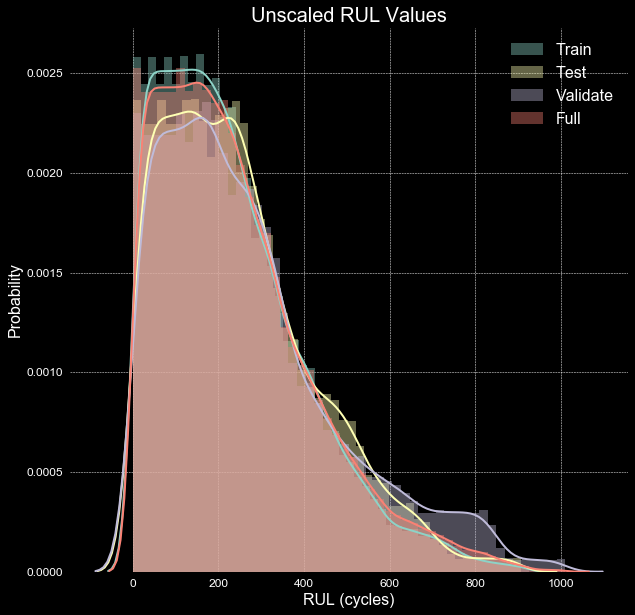

In [11]:
#Distribution plot of unscaled RUL values for each data set
plt.style.use(['bmh','dark_background']) #set global plot style

plt.figure(figsize=(10,10))
sns.distplot(train.RUL, label='Train')
sns.distplot(test.RUL, label='Test')
sns.distplot(validate.RUL, label='Validate')
sns.distplot(full.RUL, label='Full')
plt.tick_params(axis='both', which='major', labelsize=12) 
plt.legend(fontsize=16)
plt.xlabel('RUL (cycles)',fontsize=16)
plt.ylabel('Probability',fontsize=16)
plt.title('Unscaled RUL Values',fontsize=20)

#Save plot
if merge_data:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULs_unscaled_merge.png'))
else:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULs_unscaled.png'))
plt.show()

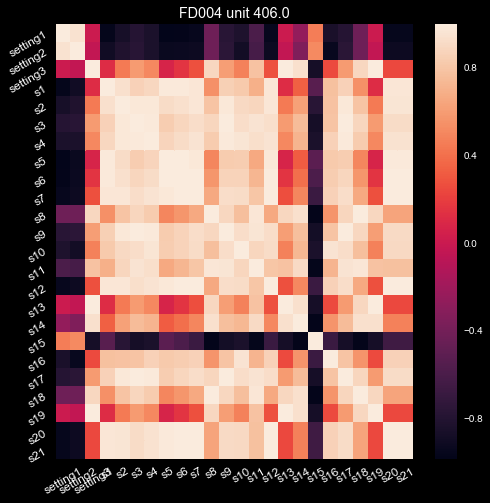

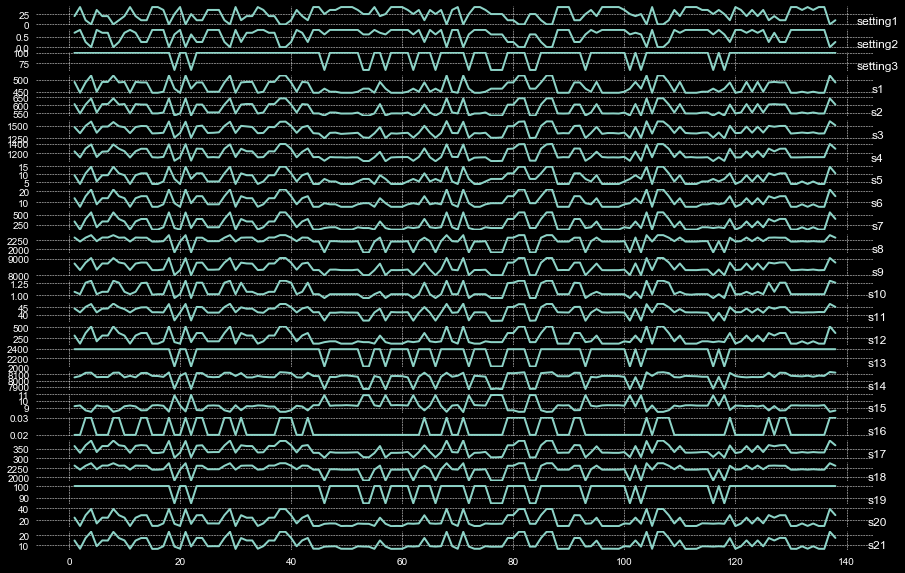

In [12]:
# plot correlations for unit i
i = np.random.choice(train.id)
df = train.loc[train.id==i].sort_values(by='cycle')
tools.plot_correlations(df, drop_cols=['id', 'cycle', 'RUL'], 
                      title='%s unit %s'%(setnumber, i), plot_path=plot_path, plot_name=setnumber)
# plot of all features values by id
tools.plot_all_measurements(df, plot_path='plots', plot_name='raw_sequences.png')

# Censor data

In [13]:
maxVal = 130 #value you wish to use as the max RUL
train['RUL']=train['RUL'].where(train['RUL'] <= maxVal, maxVal) 
test['RUL']=test['RUL'].where(test['RUL'] <= maxVal, maxVal) 
validate['RUL']=validate['RUL'].where(validate['RUL'] <= maxVal, maxVal) 
full['RUL']=full['RUL'].where(full['RUL'] <= maxVal, maxVal) 

In [14]:
#Save data
if merge_data:
    full.to_csv(os.path.join(data_path, 'full_'+setnumber+'_Censored_merge.csv'), index=False)
    train.to_csv(os.path.join(data_path, 'train_'+setnumber+'_Censored_merge.csv'), index=False)
    test.to_csv(os.path.join(data_path, 'test_'+setnumber+'_Censored_merge.csv'), index=False)
    validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'_Censored_merge.csv'), index=False)
else:
    full.to_csv(os.path.join(data_path, 'full_'+setnumber+'_Censored.csv'), index=False)
    train.to_csv(os.path.join(data_path, 'train_'+setnumber+'_Censored.csv'), index=False)
    test.to_csv(os.path.join(data_path, 'test_'+setnumber+'_Censored.csv'), index=False)
    validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'_Censored.csv'), index=False)

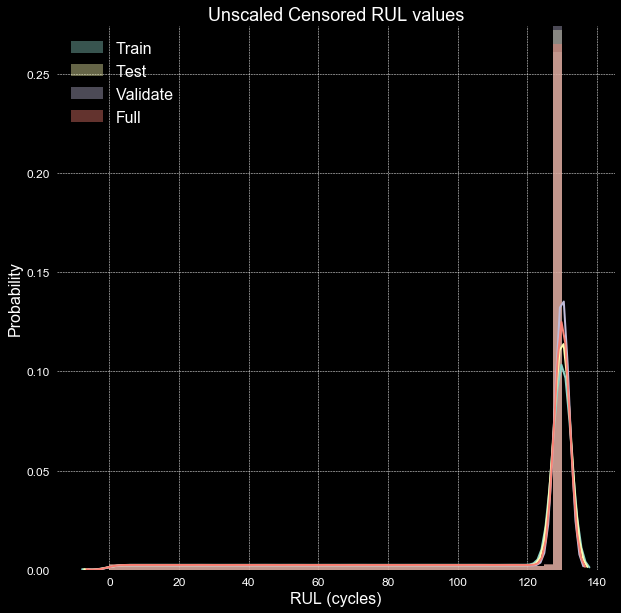

In [15]:
#Distribution plot of unscaled censored RUL values for each data set 
plt.figure(figsize=(10,10))
sns.distplot(train.RUL, label='Train')
sns.distplot(test.RUL, label='Test')
sns.distplot(validate.RUL, label='Validate')
sns.distplot(full.RUL, label='Full')
plt.tick_params(axis='both', which='major', labelsize=12) 
plt.legend(fontsize=16)
plt.xlabel('RUL (cycles)',fontsize=16)
plt.ylabel('Probability',fontsize=16)
plt.title('Unscaled Censored RUL values',fontsize=18)

#Save Plot
if merge_data:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULs_censored_unscaled_merge.png'))
else:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULs_censored_unscaled.png'))
plt.show()

In [16]:
# SCALE DATA
#normalize features (using MinMaxScaler or one of the many alternatives)

#Remove id, cycle, and RUL for scaling
train_scalables = train[train.columns.difference(['id', 'cycle','RUL'])].values
test_scalables = test[test.columns.difference(['id', 'cycle','RUL'])].values
validate_scalables = validate[validate.columns.difference(['id', 'cycle','RUL'])].values
full_scalables = full[full.columns.difference(['id', 'cycle','RUL'])].values

scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_scalables)

#scaler for censored data
#scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_scalables)

#scaler for uncensored data
# scaler = sklearn.preprocessing.RobustScaler().fit(train_scalables)

#Alternatives to minmax and robust scalers
# QuantileTransformer
# Normalizer
# StandardScaler

full_values = scaler.transform(full_scalables)
train_values = scaler.transform(train_scalables)
test_values = scaler.transform(test_scalables)
validate_values = scaler.transform(validate_scalables)
    
#Add features back to data frame    
train[train.columns.difference(['id', 'cycle','RUL'])] = train_values
test[test.columns.difference(['id', 'cycle','RUL'])] = test_values
validate[validate.columns.difference(['id', 'cycle','RUL'])] = validate_values
full[full.columns.difference(['id', 'cycle','RUL'])] = full_values

#Check values
test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,9.0,1.0,0.595153,0.736342,0.0,0.238089,0.012593,0.039456,0.051831,0.293184,...,0.001791,0.070310,0.928562,0.0,0.031250,0.000000,0.0,0.144635,0.141392,130.0
1,9.0,2.0,0.238209,0.296912,1.0,0.597937,0.634801,0.668360,0.673448,0.617180,...,0.993249,0.693606,0.146959,1.0,0.697917,0.854123,1.0,0.621931,0.626283,130.0
2,9.0,3.0,0.999776,0.997625,1.0,0.000000,0.127953,0.285142,0.224018,0.000000,...,0.993249,0.572992,0.377845,0.0,0.281250,0.627907,1.0,0.016818,0.017392,130.0
3,9.0,4.0,0.238059,0.296912,1.0,0.597937,0.630297,0.667043,0.660286,0.617180,...,0.993332,0.690312,0.144122,1.0,0.697917,0.854123,1.0,0.621258,0.623980,130.0
4,9.0,5.0,0.000010,0.001781,1.0,1.000000,0.977388,0.926813,0.889564,1.000000,...,0.993167,0.686681,0.057289,1.0,0.927083,1.000000,1.0,0.971746,0.971378,130.0


In [17]:
## SEPARATE FEATURES AND LABELS
## Drop id and cycle columns
full_X = full[full.columns.difference(['RUL','id', 'cycle'])].values
full_y = full['RUL'].values

train_X = train[train.columns.difference(['RUL','id', 'cycle'])].values
train_y = train['RUL'].values

test_X = test[test.columns.difference(['RUL','id', 'cycle'])].values
test_y = test['RUL'].values

validate_X = validate[validate.columns.difference(['RUL','id', 'cycle' ])].values
validate_y = validate['RUL'].values

In [18]:
## COMPONENT ANALYSIS
nc=24 #start with the max number of features (24)
pca = sklearn.decomposition.PCA(n_components=nc).fit(train_X)

[75.98 96.58 99.39 99.71 99.85 99.92 99.96 99.98 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99]


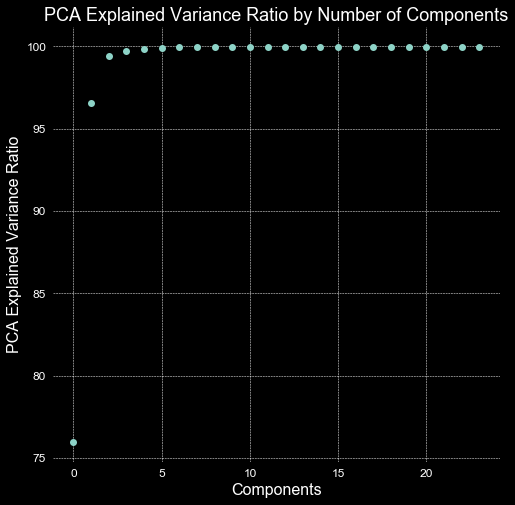

In [19]:
var= pca.explained_variance_ratio_
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1) #18 components is optimal
#when value seizes to change this implies you are no longer gaining information 
#from additional components therefore you can begin to reduce dimensionality of you feature vector

#Plot of componnents by variance explained ratio
plt.figure(figsize=(8,8))
plt.plot(var1,'o')
plt.tick_params(axis='both', which='major', labelsize=12) 
plt.title('PCA Explained Variance Ratio by Number of Components',fontsize=18)
plt.xlabel('Components',fontsize=16)
plt.ylabel('PCA Explained Variance Ratio',fontsize=16)

#Save Plot
if merge_data:
    plt.savefig(os.path.join(plot_path, setnumber+'_PCA_Variance_Ratio_merge.png'))
else:
    plt.savefig(os.path.join(plot_path, setnumber+'_PCA_Variance_Ratio.png'))
plt.show()


In [20]:
#PCA Transformation
nc=21 # choose the optimal number of components for transformation

pca = sklearn.decomposition.PCA(n_components=nc).fit(train_X)
fullX = pca.transform(full_X)
trainX = pca.transform(train_X)
testX = pca.transform(test_X)
validateX = pca.transform(validate_X)

In [21]:
#Rename features by component number and add RUL to each dataframe
X_full = pd.DataFrame(fullX, columns=['comp_'+str(x) for x in range(1, fullX.shape[1]+1)])
X_full['RUL'] = full['RUL']

X_train = pd.DataFrame(trainX, columns=['comp_'+str(x) for x in range(1, trainX.shape[1]+1)])
X_train['RUL'] = train['RUL']

X_test = pd.DataFrame(testX, columns=['comp_'+str(x) for x in range(1, testX.shape[1]+1)])
X_test['RUL'] = test['RUL']

X_validate = pd.DataFrame(validateX, columns=['comp_'+str(x) for x in range(1, validateX.shape[1]+1)])
X_validate['RUL'] = validate['RUL']

In [22]:
# Save the PCA preprocessed data

#Add id and cycle back to data frame
X_train['id'] = train['id']
X_train['cycle'] = train['cycle']
X_validate['id'] = validate['id']
X_validate['cycle'] = validate['cycle']
X_test['id'] = test['id']
X_test['cycle'] = test['cycle']

#Save data
if merge_data:
    X_full.to_csv(os.path.join(data_path, 'full_'+setnumber+'_PC_merge.csv'), index=False)
    X_train.to_csv(os.path.join(data_path, 'train_'+setnumber+'_PC_merge.csv'), index=False)
    X_test.to_csv(os.path.join(data_path, 'test_'+setnumber+'_PC_merge.csv'), index=False)
    X_validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'_PC_merge.csv'), index=False)
else:
    X_full.to_csv(os.path.join(data_path, 'full_'+setnumber+'_PC.csv'), index=False)
    X_train.to_csv(os.path.join(data_path, 'train_'+setnumber+'_PC.csv'), index=False)
    X_test.to_csv(os.path.join(data_path, 'test_'+setnumber+'_PC.csv'), index=False)
    X_validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'_PC.csv'), index=False)

In [23]:
#FOR PCA DATA
#Prepare data
X_trainc=X_train.drop(['RUL'], axis=1)
y_trainc=X_train.loc[:, X_train.columns == 'RUL']
X_testc=X_test.drop(['RUL'], axis=1)
y_testc=X_test.loc[:, X_test.columns == 'RUL']

#Reshape data (must add another dimension of 1 as Conv1D require a 3dimensional object as an input)
X_trainc = np.expand_dims(X_trainc, axis=2)
X_testc = np.expand_dims(X_testc, axis=2)

#validation preparation
X_validatec=X_validate.drop(['RUL'], axis=1)
y_validatec=X_validate.loc[:, X_validate.columns == 'RUL']

#Reshape data
X_validatec = np.expand_dims(X_validatec, axis=2)

#Check Shape
X_trainc.shape

(70859, 23, 1)

# Deep CBRNN

In [58]:
#Deep CNN settings
set_random_seed(2) # makes results replicable for keras
input_dim = 1 #
maxlen= X_trainc.shape[1] #23 #number of features
dropout = 0.5 #dropout rate
batch_size = 500 #smaller batch sizes lead to longer training times
epochs =50

model = Sequential()# Defines the type of net as sequential meaning the model is composed of 
model.add(Conv1D(nb_filter=48, filter_length=2, input_shape=(maxlen,input_dim),border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU()) 
model.add(AveragePooling1D(pool_size=2, strides=None, padding='same'))
#model.add(MaxPooling1D(2))
model.add(Dropout(dropout,noise_shape=None, seed=None))
model.add(Bidirectional(LSTM(20)))
model.add(BatchNormalization())
model.add(LeakyReLU()) 
model.add(Dense(24))
model.add(LeakyReLU()) 
#model.add(Dense(24))
model.add(Dense(1, activation='linear'))


#define root mean squared error to make results comparable to other literature
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def score(y_true, y_pred):
    d = y_pred - y_true
    mask = K.less(y_pred, y_true)  # element-wise True where y_pred < y_true
    mask = K.cast(mask, K.floatx())  # cast to 0.0 / 1.0
    return mask * (K.exp(-d / 10) - 1) + (1 - mask) * (K.exp(d / 13) - 1)  
    # every i where mask[i] is 1, s[i] == (K.exp(-d / 10) - 1)
    # every i where mask[i] is 0, s[i] == (K.exp(d / 13) - 1)
    #return s
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam=keras.optimizers.Adam(lr=0.005)
model.compile(loss='mse', optimizer=adam, metrics=[rmse,score])
#model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# CNN

In [26]:
#Convnet settings
input_dim = 1 #
maxlen= 23 #number of features
dropout = 0.15 #dropout rate
batch_size = 500 #smaller batch sizes lead to longer training times
epochs =50 

model = Sequential()# Defines the type of net as sequential meaning the model is composed of 
model.add(Conv1D(nb_filter=48, filter_length=2, input_shape=(maxlen,input_dim),border_mode='valid'))
model.add(BatchNormalization())
model.add(LeakyReLU()) 
model.add(AveragePooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Dropout(dropout,noise_shape=None, seed=None))

model.add(Conv1D(48, 2, activation='relu'))
model.add(LeakyReLU()) 
model.add(AveragePooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Dropout(dropout,noise_shape=None, seed=None))

model.add(Flatten())
model.add(Dense(1, activation='relu'))
#model.add(TimeDistributed(Dense(1, activation='sigmoid')))

#define root mean squared error to make results comparable to other literature
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer='adam', metrics=[rmse,'mae'])
#model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# LSTM

In [25]:
#Convnet settings
input_dim = 1 #
maxlen= 23 #number of features
dropout = 0.15 #dropout rate
batch_size = 500 #smaller batch sizes lead to longer training times
epochs =50 


model = Sequential()
model.add(Bidirectional(LSTM(input_dim, return_sequences=True),
                        input_shape=(maxlen,input_dim)))
model.add(Dropout(dropout,noise_shape=None, seed=None))
model.add(Bidirectional(LSTM(20)))
model.add(BatchNormalization())
model.add(LeakyReLU()) 
model.add(Dense(24))
model.add(LeakyReLU()) 
#model.add(Dense(24))
model.add(Dense(1, activation='linear'))

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam=keras.optimizers.Adam(lr=0.001)
model.compile(loss='mse', optimizer=adam, metrics=[rmse])
#model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [41]:
#Fitmodel
import timeit

start = timeit.default_timer()

#Without dynamic learning rate
#lr.001 230.66 hist=model.fit(X_trainc,y_trainc,batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_testc, y_testc))
#lr.01  hist1 238.79
#lr.005 236.41
hist2=model.fit(X_trainc,y_trainc,batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_testc, y_testc))
stop = timeit.default_timer()
print('Time: ', stop - start) 

Train on 70859 samples, validate on 14887 samples
Epoch 1/33
70859/70859 [==============================] - 9s 130us/step - loss: 4026.4992 - rmse: 46.8841 - score: 44715.2997 - val_loss: 822.7712 - val_rmse: 21.8204 - val_score: 40.2435
Epoch 2/33
70859/70859 [==============================] - 6s 88us/step - loss: 776.7107 - rmse: 18.5666 - score: 56.6088 - val_loss: 686.4509 - val_rmse: 18.6467 - val_score: 35.7748
Epoch 3/33
70859/70859 [==============================] - 6s 88us/step - loss: 756.8463 - rmse: 18.2300 - score: 52.2561 - val_loss: 602.5729 - val_rmse: 14.9739 - val_score: 36.6057
Epoch 4/33
70859/70859 [==============================] - 6s 88us/step - loss: 744.8239 - rmse: 17.8597 - score: 52.3390 - val_loss: 633.3453 - val_rmse: 16.0365 - val_score: 38.9941
Epoch 5/33
70859/70859 [==============================] - 7s 93us/step - loss: 733.4796 - rmse: 17.5209 - score: 50.3951 - val_loss: 666.3728 - val_rmse: 16.6037 - val_score: 45.6681
Epoch 6/33
70859/70859 [======

In [59]:
#Fitmodel
#With Dynamic learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000000000005, verbose=1) 

start = timeit.default_timer()
# 0.001 67.94855696999002 history 102.87284670499503
#.01 0.42286805699405 history1 105.54571977599699
# 0.005 71.46780841900909
history2 =model.fit(X_validatec,y_validatec,batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_testc, y_testc),shuffle=True, callbacks=[reduce_lr])


stop = timeit.default_timer()
print('Time: ', stop - start) 


Train on 16717 samples, validate on 14887 samples
Epoch 1/50
16717/16717 [==============================] - 6s 366us/step - loss: 11654.1058 - rmse: 102.4046 - score: 183013.2422 - val_loss: 3786.8189 - val_rmse: 51.7021 - val_score: 57830.3788
Epoch 2/50
16717/16717 [==============================] - 2s 106us/step - loss: 4101.9842 - rmse: 54.9956 - score: 66779.3887 - val_loss: 6132.8363 - val_rmse: 73.8469 - val_score: 7177.5264
Epoch 3/50
16717/16717 [==============================] - 2s 108us/step - loss: 872.3667 - rmse: 20.2972 - score: 2811.7277 - val_loss: 6556.2628 - val_rmse: 77.1758 - val_score: 4895.3618
Epoch 4/50
16717/16717 [==============================] - 2s 109us/step - loss: 730.0841 - rmse: 18.0507 - score: 80.1350 - val_loss: 3209.2703 - val_rmse: 52.1458 - val_score: 594.9456
Epoch 5/50
16717/16717 [==============================] - 2s 105us/step - loss: 690.3210 - rmse: 17.3667 - score: 50.5543 - val_loss: 2765.5403 - val_rmse: 47.4971 - val_score: 533.1678
Epo

In [100]:
#Summary of neural network architecture 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 23, 48)            144       
_________________________________________________________________
batch_normalization_66 (Batc (None, 23, 48)            192       
_________________________________________________________________
leaky_re_lu_92 (LeakyReLU)   (None, 23, 48)            0         
_________________________________________________________________
average_pooling1d_16 (Averag (None, 12, 48)            0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 12, 48)            0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 40)                11040     
_________________________________________________________________
batch_normalization_67 (Batc (None, 40)                160       
__________

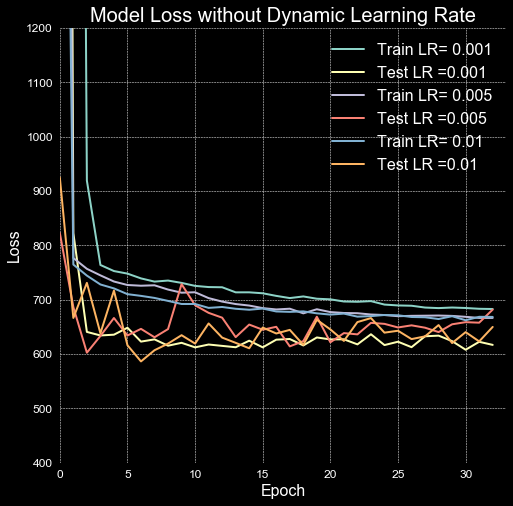

In [45]:
#Model performance by epoch
#Without dynamic learning rate
plt.figure(figsize=(8,8)) 
plt.plot(hist.history['loss']) 
plt.plot(hist.history['val_loss']) 
plt.plot(hist2.history['loss']) 
plt.plot(hist2.history['val_loss']) 
plt.plot(hist1.history['loss']) 
plt.plot(hist1.history['val_loss']) 

plt.xlim(0, 33)
plt.ylim(400, 1200)
plt.tick_params(axis='both', which='major', labelsize=12) 
plt.title('Model Loss without Dynamic Learning Rate',fontsize=20) 
plt.ylabel('Loss',fontsize=16) 
plt.xlabel('Epoch',fontsize= 16) 
plt.legend(['Train LR= 0.001', 'Test LR =0.001 ','Train LR= 0.005', 'Test LR =0.005 ','Train LR= 0.01', 'Test LR =0.01 '], loc='best',fontsize=16)

#Save plot   
if merge_data:
    plt.savefig(os.path.join(plot_path, setnumber+'LR.png'))
else:
    plt.savefig(os.path.join(plot_path, setnumber+'LR.png'))
plt.show()

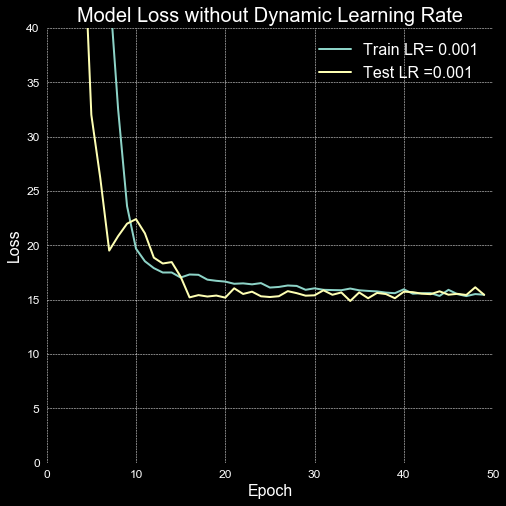

In [70]:
#Model performance by epoch
#Without dynamic learning rate
plt.figure(figsize=(8,8)) 
# plt.plot(history.history['loss']) 
# plt.plot(history.history['val_loss']) 
# plt.plot(history2.history['loss']) 
# plt.plot(history2.history['val_loss']) 
# plt.plot(history1.history['loss']) 
# plt.plot(history1.history['val_loss']) 


plt.plot(history.history['rmse']) 
plt.plot(history.history['val_rmse']) 
# plt.plot(history2.history['rmse']) 
# plt.plot(history2.history['val_rmse']) 
# plt.plot(history1.history['rmse']) 
# plt.plot(history1.history['val_rmse']) 


plt.xlim(0, 50)
plt.ylim(0, 40)
plt.tick_params(axis='both', which='major', labelsize=12) 
plt.title('Model Loss without Dynamic Learning Rate',fontsize=20) 
plt.ylabel('Loss',fontsize=16) 
plt.xlabel('Epoch',fontsize= 16) 
plt.legend(['Train LR= 0.001', 'Test LR =0.001 ','Train LR= 0.005', 'Test LR =0.005 ','Train LR= 0.01', 'Test LR =0.01 '], loc='best',fontsize=16)

#Save plot   
if merge_data:
    plt.savefig(os.path.join(plot_path, setnumber+'LR4.png'))
else:
    plt.savefig(os.path.join(plot_path, setnumber+'LR4.png'))
plt.show()

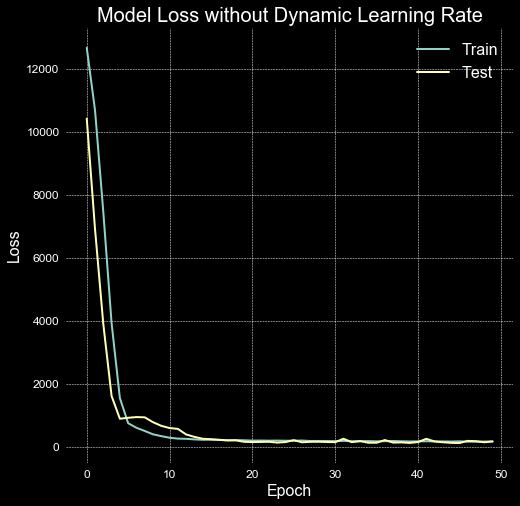

In [190]:
#Model performance by epoch
#Without dynamic learning rate
plt.figure(figsize=(8,8)) 
plt.plot(hist.history['loss']) 
plt.plot(hist.history['val_loss']) 
plt.tick_params(axis='both', which='major', labelsize=12) 
plt.title('Model Loss without Dynamic Learning Rate',fontsize=20) 
plt.ylabel('Loss',fontsize=16) 
plt.xlabel('Epoch',fontsize= 16) 
plt.legend(['Train', 'Test'], loc='best',fontsize=16)

#Save plot   
if merge_data:
    plt.savefig(os.path.join(plot_path, setnumber+'_Loss_wo_DLR_merge_BiCNN.png'))
else:
    plt.savefig(os.path.join(plot_path, setnumber+'_Loss_wo_DLR_BiCNN.png'))
plt.show()

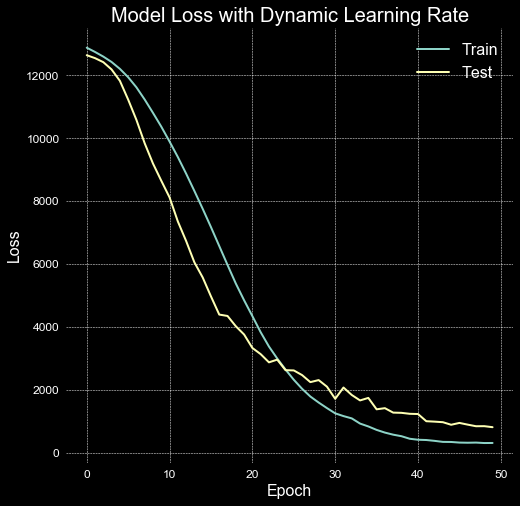

In [54]:
#Model performance by epoch
#With dynamic learning rate
plt.figure(figsize=(8,8)) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.tick_params(axis='both', which='major', labelsize=12) 
plt.title('Model Loss with Dynamic Learning Rate',fontsize=20) 
plt.ylabel('Loss',fontsize=16) 
plt.xlabel('Epoch',fontsize= 16) 
plt.legend(['Train', 'Test'], loc='best',fontsize=16)

#Save plot   
if merge_data:
    plt.savefig(os.path.join(plot_path, setnumber+'_Loss_DLR_mergeCNNBRNN.png'))
else:
    plt.savefig(os.path.join(plot_path, setnumber+'_Loss_DLCNNBRNN.png'))
plt.show()

In [145]:
#Convert predictions and actual values of RUL to dataframe
y_hat=model.predict(X_testc,batch_size) #predict RUL values
y_hat = pd.DataFrame(y_hat) #convert predicted RUL values to dataframe
y_hat=y_hat.iloc[:, 0]  #Store predicted values of RUL
y = pd.DataFrame(y_testc) #convert actual RUL values to dataframe
y=y.iloc[:, 0] #Store actual values of RUL

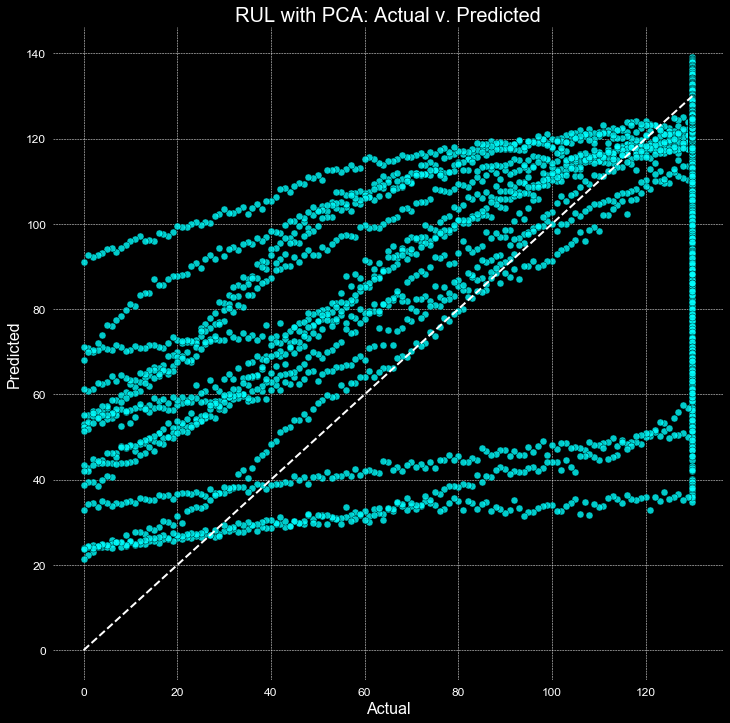

In [27]:
#Plot actual vs predicted values
with plt.style.context('dark_background'): #Set background 
    fig, ax = plt.subplots(figsize=(12,12)) #set figure size
    ax.scatter(y, y_hat, edgecolors=(0, 0, 0),color='cyan',alpha=0.8) #adjust scatter colors and transparency(alpha)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='white') # create performance line
    ax.tick_params(axis='both', which='major', labelsize=12) # adjust axis fontsize
    ax.set_xlabel('Actual',color='white',fontsize=16) # adjust x label fontsize
    ax.set_ylabel('Predicted',color='white',fontsize=16) # adjust y label fontsize
    ax.set_title("RUL with PCA: Actual v. Predicted",fontsize=20) # adjust title fontsize
 
#Save plot
if merge_data:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULvPred_PCA_merge_CNNBRNN.png'))
else:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULvPred_PCA_CNNBRNN.png'))

    plt.show() #show plot

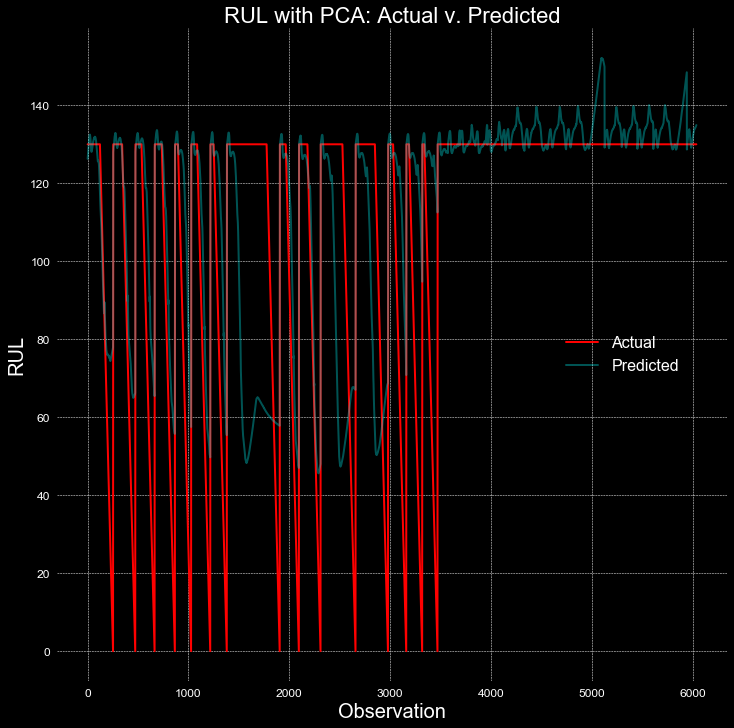

In [29]:
#Plot of actual vs predicted values by index
with plt.style.context('dark_background'): #set dark background
    fig, ax = plt.subplots(figsize=(12,12))
    ax.plot(y.index, y,color='red',alpha=1.0,label='Actual')
    ax.plot(y_hat.index, y_hat, color='cyan',alpha=0.33,label='Predicted')
    ax.set_xlabel('Observation',fontsize=20)
    ax.set_ylabel('RUL',fontsize=20)
    ax.set_title("RUL with PCA: Actual v. Predicted",fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(loc='center right', fontsize=16,bbox_to_anchor=(.95, 0.5))
    
#Save plot    
if merge_data:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULvPred_PCA_Index_merge_CNNBRNN.png'))
else:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULvPred_PCA_Index_CNNBRNN.png'))

    plt.show() #show plot
    

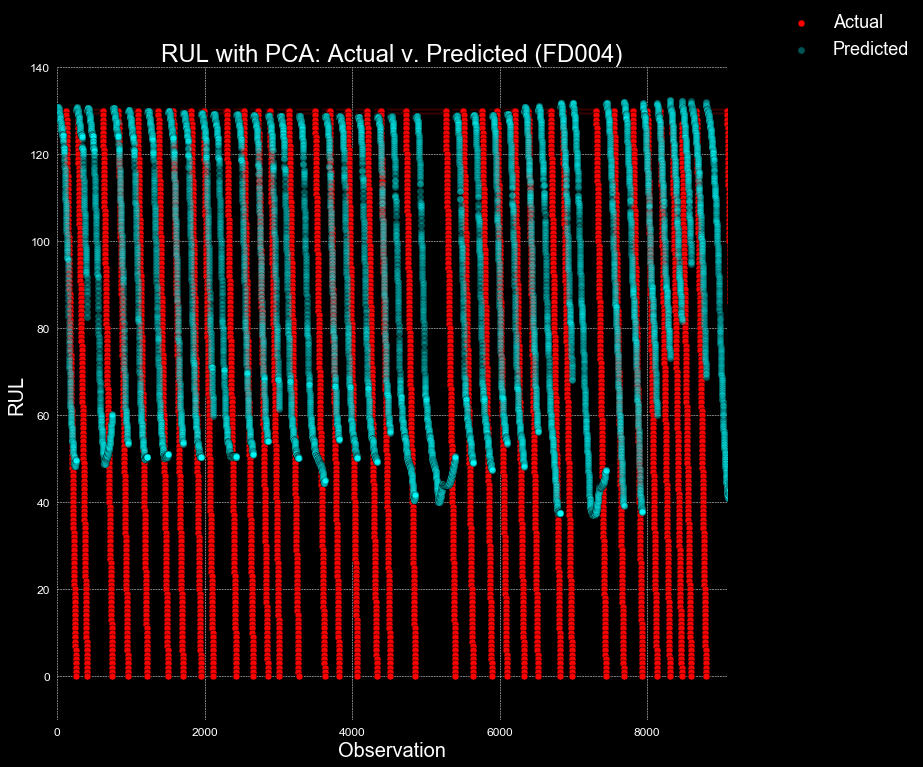

In [149]:
#Plot actual vs predicted values
with plt.style.context('dark_background'): #Set background 
    fig, ax = plt.subplots(figsize=(12,12)) #set figure size
    ax.scatter(y.index, y, edgecolors=(0, 0, 0),color='red',alpha=1.0,label='Actual') #adjust scatter colors and transparency(alpha)
    ax.scatter(y_hat.index, y_hat, edgecolors=(0, 0, 0),color='cyan',alpha=0.33, label='Predicted') # create performance line
    ax.tick_params(axis='both', which='major', labelsize=14) # adjust axis fontsize
    ax.set_ylim([-10, 140])
    ax.set_xlim([0, 9080])
    ax.set_xlabel('Observation',fontsize=20)
    ax.set_ylabel('RUL',fontsize=20)
    ax.set_title("RUL with PCA: Actual v. Predicted ("+setnumber+")" ,fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(loc='best', fontsize=18,bbox_to_anchor=(1.07, 1.),borderaxespad=0.1)

#Save plot
if merge_data:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULvPred_PCA_merge_CNNBRNN.png'))
else:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULvPred_PCA_CNNBRNN.png'))

    plt.show() #show plot